## Calculate local finite-amplitude wave activity
**22 March 2022 by MiniUFO**

---
[TOC]

---
### 1. Introduction
Wave play an important role of rearranging angular momentum in the atmosphere.  This is expressed by the generalized Eliassen-Palm (E-P) relation:
$$
\begin{align}
\frac{\partial A}{\partial t}+\nabla\cdot\mathbf F=D+O(\alpha^3) \tag{1}
\end{align}
$$
where $A$ is the density of wave activity (negative angular pseudomomentum), $\mathbf F$ the generalized E-P flux for a slowly modulated **small-amplitude** wave, and $D$ the nonconservative effects on wave density.  For small-amplitude wave, $A$ is given as:
$$
\begin{align}
A=\frac{1}{2}\frac{\overline{q'^2}}{\partial \overline{q}/\partial y} \tag{2}
\end{align}
$$

[Nakamura and Zhu (2010)](https://journals.ametsoc.org/view/journals/atsc/67/9/2010jas3432.1.xml) have proposed a new definition of wave activity to account for **finite-amplitude wave** (FAWA) and [Huang and Nakamura (2016)](https://journals.ametsoc.org/view/journals/atsc/73/1/jas-d-15-0194.1.xml) extended FAWA to be defined locally, which is called local finite-amplitude wave activity (LWA).  A simple zonal mean of LWA recovers FAWA exactly.  The key to LWA is to first sorting the PV in the meridional direction conservatively and obtain a sorted PV profile instead of a traditional zonal mean state to define eddy portion.  After some email discussions with Prof. Nakamura, I recently realize that **LWA defined in the horizontal $x-y$ plane is conceptually equivalent to local available potential energy (APE) in the vertical $x-z$ plane** (see this [notebook for local APE]()).  Here we will demonstrate how to calculate LWA under the help of [xcontour](https://github.com/miniufo/xcontour).  It will show that the whole calculation procedure is very clean and clear.

---

### 2. Theoretical guide
The LWA is defined, according to [Huang and Nakamura (2016)](https://journals.ametsoc.org/view/journals/atsc/73/1/jas-d-15-0194.1.xml), as:
$$
\begin{align}
\tilde A\left(x, y, t\right)=-\int_0^{\eta\left(x,y,t\right)}q\left(x,y+y',t\right)-Q\left(y,t\right)dy' \tag{3}
\end{align}
$$
where $\eta(x,y,t)$ represents the displacement of a tracer contour from its sorted place.

---

### 3. Calculation procedure
#### 3.1 Load data
Here for demonstrating purpose, we repeat the result of [this notebooke from Clare Huang's github repo](https://github.com/csyhuang/hn2016_falwa/blob/master/examples/simple/Example_barotropic.ipynb).  The data, barotropic (absolute) vorticity over the globe, are also downloaded from there.

First, we read in the data and calculate the conservative sorted state:

In [1]:
import xarray as xr
import numpy as np
import sys
sys.path.append('../../')
from xcontour.xcontour import Contour2D, latitude_lengths_at, add_latlon_metrics

##################################  load data  #######################################
dset = xr.open_dataset('../Data/barotropic_vorticity.nc')

# add metrics for xgcm.Grid
dset, grid = add_latlon_metrics(dset)
# get vorticity as a tracer
tracer = dset.absolute_vorticity

###########################  calculate sorted state  #################################
# Initialize equally-spaced contours from minimum value to maximum
# value (within lat/lon dims).  Here will implicitly loop over each isentropic level
%matplotlib inline
N  = 121           # increase the contour number may get non-monotonic A(q) relation
increase = True    # Y-index increases with latitude (sometimes not)
lt = True          # northward of PV contours (larger than) is inside the contour
                   # change this should not change the result of Keff, but may alter
                   # the values at boundaries
dtype = np.float32 # use float32 to save memory
undef = -9.99e8    # for maskout topography if present

# initialize a Contour2D analysis class using grid and tracer
analysis = Contour2D(grid, tracer,
                     dims={'X':'longitude','Y':'latitude'},
                     dimEq={'Y':'latitude'},
                     increase=increase,
                     lt=lt)
# evenly-spaced contours
ctr = analysis.cal_contours(N)

# Mask for A(q) relation table.
mask = xr.where(tracer!=undef, 1, 0).astype(dtype)

# calculate related quantities for 
table   = analysis.cal_area_eqCoord_table(mask) # A(Yeq) table
area    = analysis.cal_integral_within_contours(ctr).rename('intArea')
latEq   = table.lookup_coordinates(area).rename('latEq')

#####################  interpolat to equivalent latitudes  ###########################
# combined the results
ds_contour = xr.merge([ctr, area, latEq])

# interpolate from contour space to original latitudes
preLats = dset.latitude.astype(dtype)
# results in latEq space
ds_latEq = analysis.interp_to_dataset(preLats, latEq, ds_contour)

case 1: increase & lt


When we get the sorted profile of vorticity, we can calculate the LWA.

In [4]:
#%% calculate local finite-amplitude wave activity
lwa, contours, masks = analysis.cal_local_wave_activity(tracer,     # the original vorticiy
                                       ds_latEq.absolute_vorticity, # the sorted vorticity
                                       mask_idx=[37,125,170,213])   # select these mask to see the area of LWA

Now we can take a look at the results.

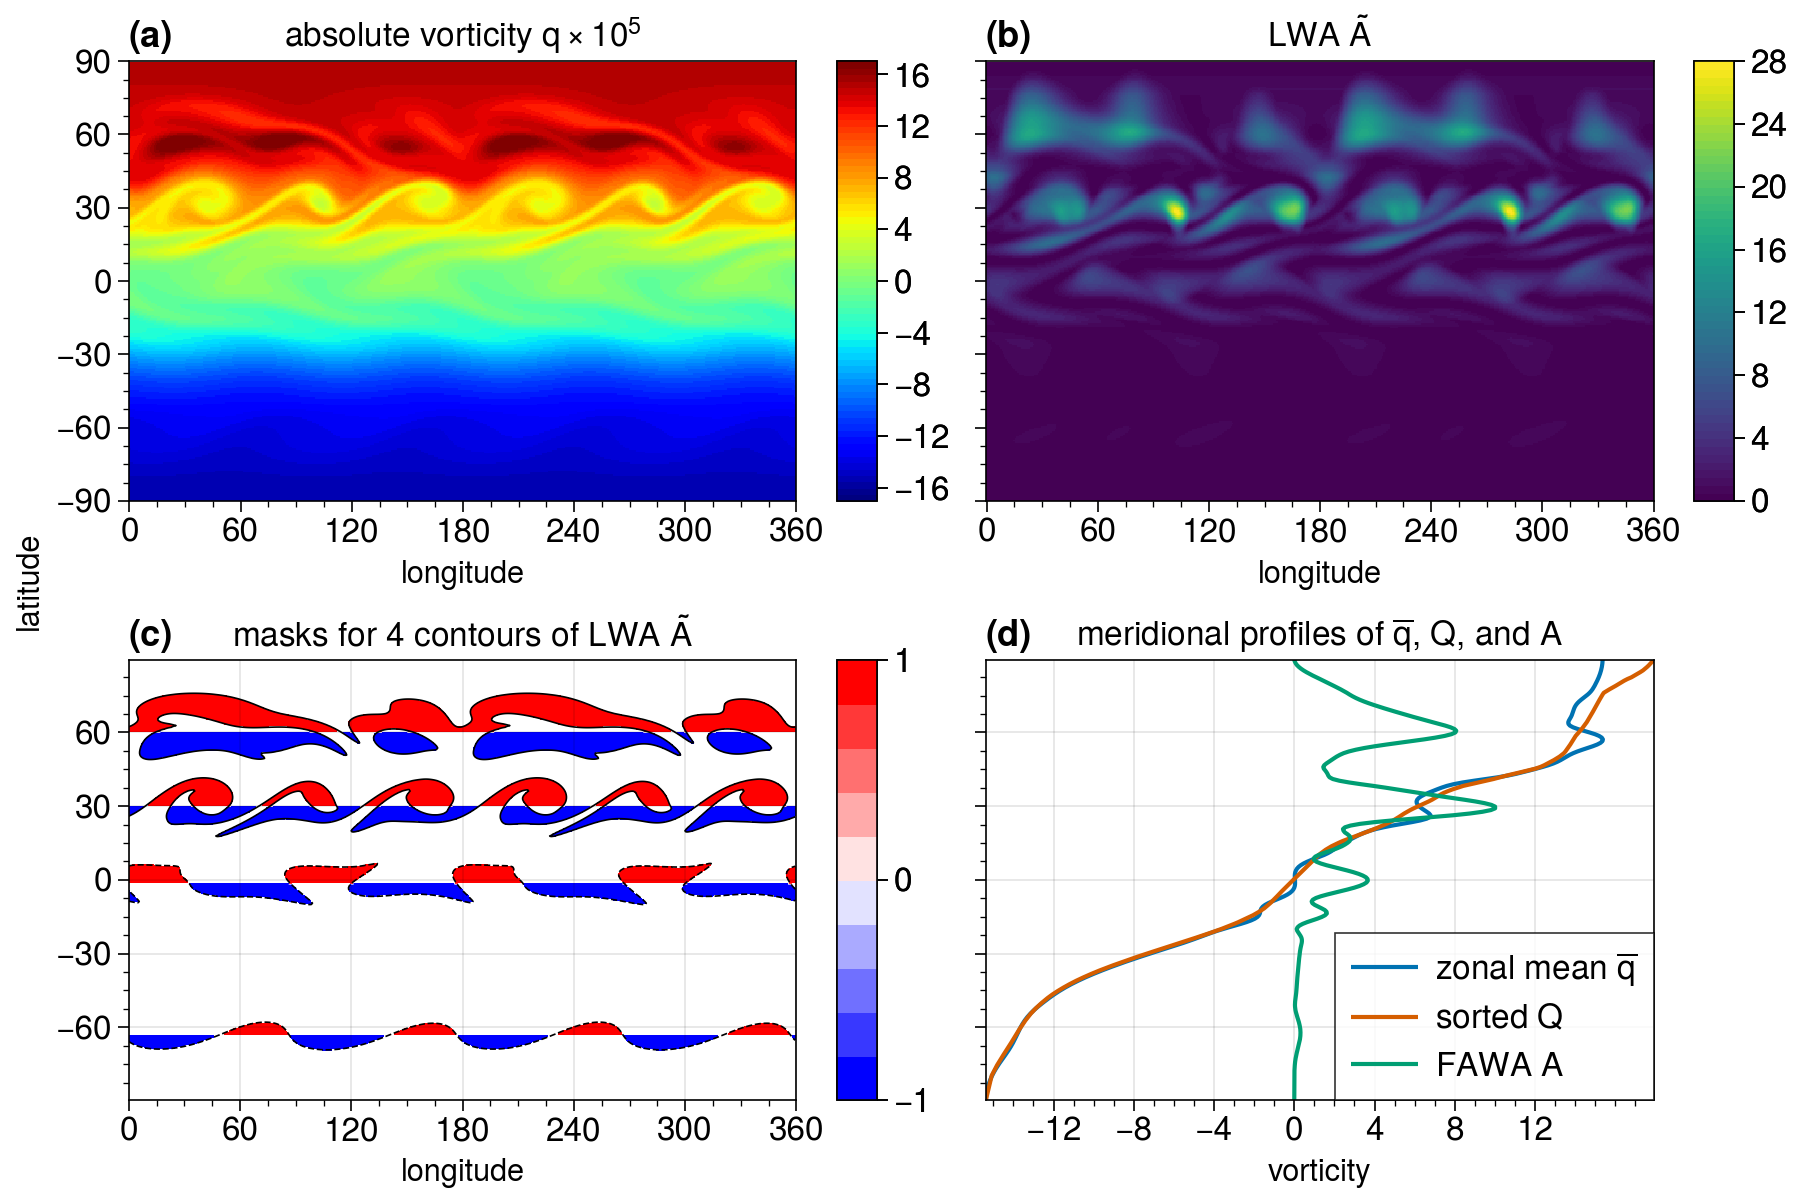

In [17]:
import proplot as pplt

fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(9, 6), sharex=0, sharey=3)

fontsize = 12

ax = axes[0, 0]
m1=ax.pcolormesh(tracer*1e5, levels=np.linspace(-17, 17, 69), cmap='jet')
ax.colorbar(m1, loc='r', ticks=4, label='')
ax.set_title('absolute vorticity $q\\times 10^5$', fontsize=fontsize)
ax.set_xlabel('longitude', fontsize=fontsize-1)
ax.set_ylabel('latitude', fontsize=fontsize-1)
ax.set_xticks([0, 60, 120, 180, 240, 300, 360])
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90])

ax = axes[0, 1]
m1=ax.pcolormesh(lwa, levels=np.linspace(0, 28, 57), cmap='viridis')
ax.colorbar(m1, loc='r', ticks=4, label='')
ax.set_title('LWA $\\tilde{A}$', fontsize=fontsize)
ax.set_xlabel('longitude', fontsize=fontsize-1)
ax.set_ylabel('latitude', fontsize=fontsize-1)
ax.set_xticks([0, 60, 120, 180, 240, 300, 360])
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90])

ax = axes[1, 0]
m1=ax.contourf(sum(masks).where(sum(masks)!=0), cmap='bwr')
ax.contour(tracer, levels=xr.concat(contours, 'latitude').values, color='k', lw=0.6)
ax.colorbar(m1, loc='r', ticks=1, label='')
ax.set_title('masks for 4 contours of LWA $\\tilde{A}$', fontsize=fontsize)
ax.set_xlabel('longitude', fontsize=fontsize-1)
ax.set_ylabel('latitude', fontsize=fontsize-1)
ax.set_xticks([0, 60, 120, 180, 240, 300, 360])
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90])

ax = axes[1, 1]
m1=ax.plot(tracer.mean('longitude')*1e5, tracer.latitude, label='zonal mean $\\overline{q}$')
m2=ax.plot(ds_latEq.absolute_vorticity*1e5, tracer.latitude, label='sorted $Q$')
m3=ax.plot(lwa.mean('longitude'), tracer.latitude, label='FAWA $A$')
ax.set_title('meridional profiles of $\\overline{q}$, $Q$, and $A$', fontsize=fontsize)
ax.set_xlabel('vorticity', fontsize=fontsize-1)
ax.set_ylabel('latitude', fontsize=fontsize-1)
ax.set_xticks([-12, -8, -4, 0, 4, 8, 12])
ax.legend([m1,m2,m3], loc='lr', ncols=1, fontsize=fontsize-1)

axes.format(abc='(a)')

It is clear that the vorticity field in (a) is characterized by six Kelvin cat's eyes.  The maxima of LWA in (b) is associated with these eyes.  The conservatively-sorted vorticity profile $Q$ in (d) is monotonic increasing with latitude, indicating barotropic stable profile.  In contrast, the zonal-mean profile $\overline{q}$ does not.  It has two obvious vorticity inversion at about 30°N and 60°N, where wave goes to finite amplitude.  The zonal-mean of LWA, that is FAWA, has two peaks at Northern Hemisphere (60°N, 30°N), a peak at equator, and a very weak one in Southern Hemisphere (62°S).  Four contours related to these four peaks and assoicated masks are also plotted in (c) for a clear view of the area (shading) used for calculating LWA.

#### References
1. Nakamura, N., and D. Zhu, 2010: [Finite-amplitude wave activity and diffusive flux of potential vorticity in eddy-mean flow interaction](https://journals.ametsoc.org/view/journals/atsc/67/9/2010jas3432.1.xml). *J. Atmos. Sci.*, **67**, 2701-2716.
2. Huang, C. S. Y., and N. Nakamura, 2016: [Local finite-amplitude wave activity as a diagnostic of anomalous weather events](https://journals.ametsoc.org/view/journals/atsc/73/1/jas-d-15-0194.1.xml). *J. Atmos. Sci.*, **73**, 211-229.
3. Clare Huang's github repo: https://github.com/csyhuang/hn2016_falwa